In [1]:
my_list = [1, 2, 3, 0, 2.4, 1.3]
sorted(my_list)

[0, 1, 1.3, 2, 2.4, 3]

# Title

## Subtitle

Some text



# 3.5 First Steps with TensorFlow

## 3.5.1 Constant tensors and *variables*

### All-ones or all-zeros tensors


In [2]:
# All-ones or all-zeros tensors

import tensorflow as tf
x = tf.ones(shape=(2,1)) # Equivalent to np.ones(shape=(2,1))
print(x)

tf.Tensor(
[[1.]
 [1.]], shape=(2, 1), dtype=float32)


In [3]:
x = tf.zeros(shape=(2,1))
print(x)

tf.Tensor(
[[0.]
 [0.]], shape=(2, 1), dtype=float32)


### Random tensors

In [4]:
x = tf.random.normal(shape=(3,1), mean=0., stddev=1.) # Equivalent to np.random.normaal(size=(3,1),loc=0., scale=1.)
print(x)

tf.Tensor(
[[-1.209368  ]
 [ 0.60747373]
 [ 0.10914377]], shape=(3, 1), dtype=float32)


In [5]:
x = tf.random.uniform(shape=(3,1),minval=0., maxval=1.) # Equivalent to np.random.uniform(size=(3,1),low=0., high=1.)
print(x)

tf.Tensor(
[[0.8789382]
 [0.4266553]
 [0.7392099]], shape=(3, 1), dtype=float32)


### NumPy arrays are assignable, TF tensors are not assignable

In [6]:
import numpy as np
x = np.ones(shape=(2,2))
x[0, 0] = 0.
print(x)

[[0. 1.]
 [1. 1.]]


In [7]:
x = tf.ones(shape=(2,2))
x[0, 0] = 0.

TypeError: 'tensorflow.python.framework.ops.EagerTensor' object does not support item assignment

### We use *variables* to manage modified states in TF.

In [8]:
v = tf.Variable(initial_value=tf.random.normal(shape=(3,1)))
print(v)

<tf.Variable 'Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[ 2.4666328 ],
       [-0.15234578],
       [-1.0575331 ]], dtype=float32)>


In [9]:
# Use assign method to to modify the state of the variable
v.assign(tf.ones((3,1)))

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[1.],
       [1.],
       [1.]], dtype=float32)>

In [10]:
v[0, 0].assign(3.)

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[3.],
       [1.],
       [1.]], dtype=float32)>

## 3.5.2 Tensor Operations: Doing math in TensorFlow

In [11]:
a = tf.ones((2,2))
b = tf.square(a) # take square of a
c = tf.sqrt(a) # square root of a
d = b + c # element-wise addition
e = tf.matmul(a,b) # tensor product
e *= d # element wise tensor multiplication

# print(a, b, c, d, e)

## 3.5.3 Second look at the *GradientTape* API

TF looks a lot like NumPy till now. Here's something NumPy can't do: get gradients of any differentiable expression w.r.t. any of its inputs.

### Using the GradientTape

In [12]:
input_var = tf.Variable(initial_value=3.)
with tf.GradientTape() as tape:
  result = tf.square(input_var) # result = x^2
gradient = tape.gradient(result, input_var) # calculates grad = 2x
print(gradient) # answer is 2x = 2*3. = 6.

tf.Tensor(6.0, shape=(), dtype=float32)


### Using GradientTape with constant tensor inputs

Only trainable variables are tracked by default. With a constant tensor, you'd have to manually mark it as being tracked by calling the tape.watch() on it.

In [14]:
input_const = tf.constant(3.)
with tf.GradientTape() as tape:
  tape.watch(input_const)
  result = tf.square(input_const)
gradient = tape.gradient(result, input_const)
print(gradient)

tf.Tensor(6.0, shape=(), dtype=float32)


### Using nested gradient tapes to compute second-order gradients

position(time) = 4.9 * time**2. Calculate the acceleration.

In [15]:
time = tf.Variable(0.)
with tf.GradientTape() as outer_tape:
  with tf.GradientTape() as inner_tape:
    position = 4.9 * time ** 2
  speed = inner_tape.gradient(position, time)
acceleration = outer_tape.gradient(speed, time)

print(acceleration)

tf.Tensor(9.8, shape=(), dtype=float32)


## 3.5.4 An end-to-end example: a linear classifier in pure TensorFlow

### Generating 2 classes of random points in a 2D plane

In [16]:
num_samples_per_class = 1000
negative_samples = np.random.multivariate_normal(
    mean=[0, 3],
    cov=[[1, 0.5], [0.5, 1]],
    size=num_samples_per_class
) # Class 1: 1000 random 2d points. cov corresponds to an oval-like point cloud oriented from bottom left to top right

positive_samples = np.random.multivariate_normal(
    mean=[3, 0],
    cov=[[1, 0.5], [0.5, 1]],
    size=num_samples_per_class
) # Class 2: another class with different mean but same covariance matrix



In [17]:
# Both classes are arrays of shape (1000, 2)
# Stack them together into a singla array of shape (2000, 2)
inputs = np.vstack((negative_samples, positive_samples)).astype(np.float32)

### Generating the corresponding targets (0 and 1)

In [18]:
targets = np.vstack((np.zeros((num_samples_per_class, 1), dtype="float32"),
                     np.ones((num_samples_per_class, 1), dtype="float32")))

### Plotting the 2 point classes using Matplotlib

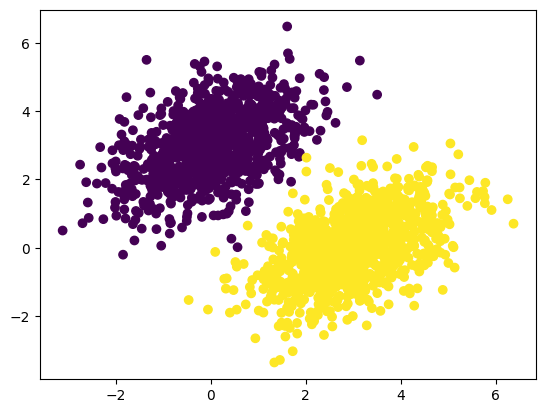

In [19]:
import matplotlib.pyplot as plt
plt.scatter(inputs[:, 0], inputs[:, 1], c=targets[:, 0])
plt.show()

Now we create a linear classifier. It is an affine transformation (prediction = W dot input + b)

### Creating the linear classifier variables

In [20]:
input_dim = 2 # inputs are 2D points
output_dim = 1 # single score per sample: close to 0 is predicted to be class 0, close to 1 for class 1
W = tf.Variable(initial_value=tf.random.uniform(shape=(input_dim, output_dim)))
b = tf.Variable(initial_value=tf.zeros(shape=(output_dim,)))

### Forward pass function

In [21]:
def model(inputs):
  return tf.matmul(inputs, W) + b

### Mean squared error (MSE) loss function

In [22]:
def square_loss(targets, predictions):
  per_sample_losses = tf.square(targets - predictions) # tensor with same shape as targets/predictions, with per sample loss scores
  return tf.reduce_mean(per_sample_losses) # average the per-sample loss scores into a single scalar loss value; reduce_mean does this

### Training step function

In [23]:
learning_rate = 0.1

def training_step(inputs, targets):
  with tf.GradientTape() as tape: # forward pass
    predictions = model(inputs)
    loss = square_loss(targets, predictions)
  grad_loss_wrt_W, grad_loss_wrt_b = tape.gradient(loss, [W, b]) # gradient of loss wrt weights
  W.assign_sub(grad_loss_wrt_W * learning_rate) # update W
  b.assign_sub(grad_loss_wrt_b * learning_rate) # update b
  return loss

### Batch training loop

We are using batch training instead of mini-batch training

In [24]:
for step in range(40):
  loss = training_step(inputs, targets)
  print(f"Loss at step {step}: {loss:.4f}")

Loss at step 0: 2.1501
Loss at step 1: 0.2304
Loss at step 2: 0.1203
Loss at step 3: 0.1012
Loss at step 4: 0.0935
Loss at step 5: 0.0875
Loss at step 6: 0.0822
Loss at step 7: 0.0774
Loss at step 8: 0.0729
Loss at step 9: 0.0689
Loss at step 10: 0.0652
Loss at step 11: 0.0618
Loss at step 12: 0.0587
Loss at step 13: 0.0558
Loss at step 14: 0.0532
Loss at step 15: 0.0508
Loss at step 16: 0.0487
Loss at step 17: 0.0467
Loss at step 18: 0.0448
Loss at step 19: 0.0432
Loss at step 20: 0.0416
Loss at step 21: 0.0402
Loss at step 22: 0.0390
Loss at step 23: 0.0378
Loss at step 24: 0.0367
Loss at step 25: 0.0357
Loss at step 26: 0.0348
Loss at step 27: 0.0340
Loss at step 28: 0.0333
Loss at step 29: 0.0326
Loss at step 30: 0.0319
Loss at step 31: 0.0314
Loss at step 32: 0.0308
Loss at step 33: 0.0303
Loss at step 34: 0.0299
Loss at step 35: 0.0295
Loss at step 36: 0.0291
Loss at step 37: 0.0288
Loss at step 38: 0.0285
Loss at step 39: 0.0282


### Plot how the model classifies the data

A given input will be classifies as "0" if its prediction value is < 0.5 and "1" if it is > 0.5

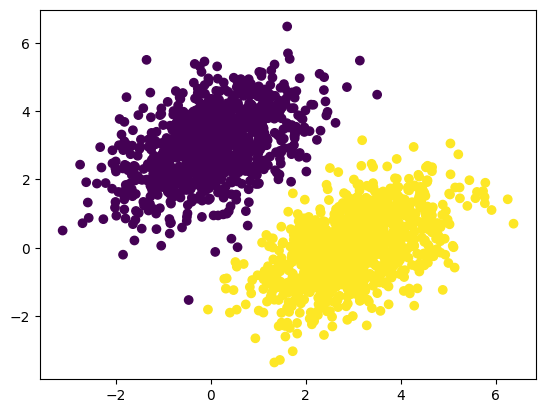

In [25]:
predictions = model(inputs)
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)
plt.show()

Prediction value for a given point [x, y] is prediction == [[w1], [w2]] dot [x, y] + b == w1*x + w2*y + b. What we are looking at is really the equation of a line in 2D: w1*x + w2*y + b = 0.5. Above the line is class 1, below the line is class 0.

This equation is same as y = -w1/w2 * x + (0.5-b) / w2

Let's plot this:

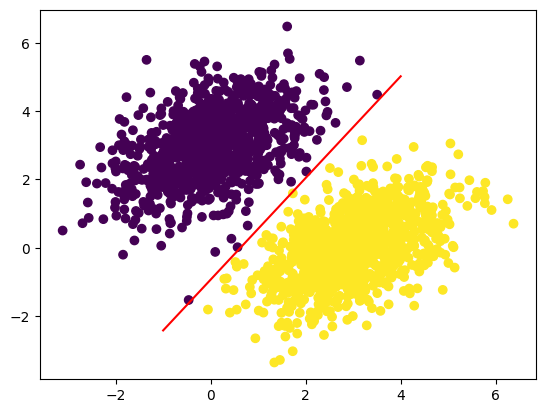

In [26]:
x = np.linspace(-1, 4, 100) # generate 100 regularly spaced numbers between -1 and 4
y = -W[0] / W[1] * x + (0.5 - b) / W[1] # line's equation
plt.plot(x, y, "-r")
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)

# 3.6 Anatomy of a neural network: Understanding cote Keras APIs

After building toy models like a batch linear classifier and a toy NN, let;s move to a more productive and more robust path to DL: Keras API.

## 3.6.1 Layers: The building blocks of deep learning

-   *Layer* is the fundamental DS in NNs.
-   Takes in one or more tensors and outputs one or more tensors
- Stateful layers: they have weights. Some are stateless.
- Different types of layers are used for different tensors/data processings:
  - For simple vector data (samples, features), we use *densely connected*/*fully connected*/*dense* layers. Using **Dense** class in Keras.
  - Sequential data, stored in rank-3 tensors of (samples, timesteps, features), is processed by *recurrent* layers like LSTM or 1D *convolutional layers* or *Conv1D*.
  - Image data stored in rank-4 tensors use 2D convolutional layers or *Conv2D* in Keras.


  The **Layer** class in Keras is a simple abstraction around which everything in centered.
  - **Layer** object encapsulates weights (state) and forward pass (computation).
  - Weighta are defined in a **build()**, or in **__init()__**
  - Computation is defined in the **call()** method.


### A Dense layer implemented as a Layer subclass

In [27]:
from tensorflow import keras

class SimpleDense(keras.layers.Layer): # all Keras layers inherit from the base Layer class
  def __init__(self, units, activation=None):
    super().__init__()
    self.units = units
    self.activation = activation

  def build(self, input_shape): # Weight creation happens here
    input_dim = input_shape[-1]
    self.W = self.add_weight(shape=(input_dim, self.units),
                             initializer="random_normal")
    self.b = self.add_weight(shape=(self.units,),
                             initializer="zeros") # add_weight() is a shortcut method for creating weights. We can also do this by
                                                  # self.W = tf.Variable(tf.random.uniform(w_shape)).

  def call(self, inputs): # forward pass computation is defined in the call() method
    y = tf.matmul(inputs, self.W) + self.b
    if self.activation is not None:
      y = self.activation(y)
    return y


# The __call__() method schematically looks like this:
# def __call__(self, inputs):
#   if not self.built:
#     self.build(inputs.shape)
#     self.built = True
#   return self.call(inputs)

# Keras uses Automatic shape inference which makes it easier to write code, and the inputs of a layer are infered from the layer
# before automatically

### This above layer can now be used just like a function, taking as input a TensorFlow tensor:

In [28]:
my_dense = SimpleDense(units=32, activation=tf.nn.relu)
input_tensor = tf.ones(shape=(2, 784))
output_tensor = my_dense(input_tensor)
print(output_tensor.shape)

(2, 32)


### **IMPORTANT**: when implementing your ow layers, put the forward pass in the *call()* method

## 3.6.2 From layers to models

- A DL model is a graph of layers
- In Keras, it's a Model class
- Other varieties of network topologies, other than Sequential:
  - Two-branch networks
  - Multihead networks
  - Residual connections
- Topology of a model defines a *hypothesis space*. By choosing a topology, we constrain the hypothesis space or space of possibilities.
- To learn from data, we need to make assumptions about it.
- The model architecture we choose is important——it encodes the assumptions we make about our problem.
  - Example: if we work on a two-class classification problem with a model made of a single Dense layer with no activation (pure affine transformation), we're assuming that the two classes are linearly separable.
- *Picking the right architecture is more art than science*.
- Only practice can help you become a proper NN architect.

## 3.6.3 The "compile" step: Configuring the learning process

Once the model architecture is picked, we need to do 3 more things:
- *Loss function (objective function)*
- *Optimizer*: implements a specific variant of SGD
- *Metric*: the measure of success

Once we've picked these, we can use the built-in compile() and fit() methods to start training our model.

`compile()` method configures the training process:
```python
model = keras.Sequential([keras.layers.Dense(1)]) # define a linear classifier
model.compile(optimizer="rmsprop", # RMSprop is an optimizer
              loss="mean_squared_error", # specify the loss by name
              metrics=["accuracy"]) # metrics is a list

# Another way to do this:

model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-4),
              loss=my_custom_loss,
              metrics=[my_custom_metric_1, my_custom_metric_2])

```

#### Keras has a wide range of built-in options like:

- Optimizers
  - SGD (with or without momentum)
  - RMPprop
  - Adam
  - Adagrad, etc.

- Losses:
  - CategoricalCrossEntropy
  - SparseCategoricalCrossEntropy
  - BinaryCrossEntropy
  - MeanSquaredError
  - KLDivergence
  - CosineSimilarity, etc.

- Metrics:
  - CategoricalAccuracy
  - SparseCategoricalAccuracy
  - BinaryAccuracy
  - AUC
  - Precision
  - Recall, etc.

## 3.6.4 Picking a loss function

- Choosing a right loss function is extremely important.
- Otherwise your network might end up doing things that you may not have wanted.
- All NNs you build will be just as ruthless in lowering their loss functions——so choose it carefully.
- Simple guidelines exist like: choose binary crossentropy for 2-class classification, categorical crossentropy for multi-class, and so on.
- Only when you are into truly new research problem is when you'll need to write your own loss functions.

## 3.6.5 Understanding the *fit()* method

After compile() comes fit(). This method implements the training loop itself. Its key arguments are:
- The *data*: inputs and targets (either as NumPy array or TF Dataset)
- The number of *epochs*.
- The *batch size*.

```python

# Calling fit() with NumPy data:

history = model.fit(
  inputs, # numpy array
  targets, # numpy array
  epochs=5,
  batch_size=128
)

```

NOTE: `fit()` returns a `History` object: a dictionary with keys such as "loss" and their per-epoch values.

## 3.6.6 Monitoring loss and metrics on validation data

- Goal of an ML model is not to perform well on just the training data (this is easy). The goal is to perform well on data it has not seen before.
- If a model performs well on training data doesn't mean it will perform well on new data.
- To look for this, we reserve a subset of the training data as the ***validation data***: won't train the model on this data, but use it to compute a loss value and metrics value.
- Done using the `validation_data` argument in `fit()`. Can pass the validation data as NumPy arrays or TF `Dataset` object.

### Using the `validation_data` argument

In [29]:
model = keras.Sequential([keras.layers.Dense(1)])
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.1),
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.BinaryAccuracy()])

# To avoid samples of only one class, we shuffle the indices:
indices_permutation = np. random.permutation(len(inputs))
shuffled_inputs = inputs[indices_permutation]
shuffled_targets = targets[indices_permutation]

# Reserve 30% of input data as validation
num_validation_samples = int(0.3 * len(inputs))
val_inputs = shuffled_inputs[: num_validation_samples]
val_targets = shuffled_targets[: num_validation_samples]
training_inputs = shuffled_inputs[num_samples_per_class : ]
training_targets = shuffled_targets[num_samples_per_class : ]

model.fit(
    training_inputs,
    training_targets,
    epochs=5,
    batch_size=16,
    validation_data=(val_inputs, val_targets)
)

Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - binary_accuracy: 0.6809 - loss: 2.0627 - val_binary_accuracy: 0.9967 - val_loss: 0.0278
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.9529 - loss: 0.0710 - val_binary_accuracy: 0.9933 - val_loss: 0.0307
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.9677 - loss: 0.0711 - val_binary_accuracy: 0.9950 - val_loss: 0.0288
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.9649 - loss: 0.0609 - val_binary_accuracy: 0.9900 - val_loss: 0.0716
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.9652 - loss: 0.0788 - val_binary_accuracy: 0.9917 - val_loss: 0.0328


- Value of loss on the validation data is called the "validation loss", distinguish from "training loss"
- Essential to keep the training and validation data separate. If the model sees any of the validation data, your validation loss and metrics will be flawed.

- To compute the validation loss and metrics *after the training* is complete, we can use the `evaluate()` method:
  - Returns a list of scalars, first entry is the validation loss, an following are the validation metrics (if any specified).

In [30]:
loss_and_metrics = model.evaluate(val_inputs, val_targets, batch_size=128)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - binary_accuracy: 0.9900 - loss: 0.0320 


## 3.6.7 Inference: Using a model after training

- Using a trained model to make predictions on new data is called ***inference***.
- Using `__call()__` method on all of new data is naive and not efficient as it takes up all the data at once. Not feasible if there's a lot of data.
- Instead, we use `predict()` method.
  - Iterates in small batches, returns a NumPy array of predictions.
  - Unlike `__call__()`, it can also process TF `Dataset` objects.

Let's use the `predict()` method on some of our validation data with the linear model we trained earlier:

In [35]:
predictions = model.predict(val_inputs, batch_size=128)
print(predictions[:10])

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
[[ 0.13215083]
 [-0.14608017]
 [-0.486137  ]
 [-0.15149108]
 [ 0.14673156]
 [ 0.6065421 ]
 [ 1.1649822 ]
 [ 0.46527222]
 [ 0.9663472 ]
 [-0.18551514]]


# Summary:

- TF is an industry-strength numerical computing framework, can run on CPU, GPU, or TPU. Can compute gradient automatically gradients, be distributed to many devices, and export programs to various external runtimes——even JavaScript.
- Keras is the standard API for doing DL with TensorFlow.
- Key TF objects: tensors, variables, tensor operations, gradient tape, etc.
- Central class of Keras is `Layer`: encapsulates weights and computation. Layers are assembled into *models*.
- Before training, gotta pick an *optimizer*, a *loss*, and some *metrics*, specified via the `model.compile()` method.
- To train the model, use the `fit()` method: it runs mini-batch GD. Can use it to monitor loss and metrics on the *validation data*.
- Once trained, we use the `model.predict()` method to generate predictions on new inputs.